In [2]:
#import
import pandas as pd
import numpy as np
import textdistance
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.cluster import KMeans

##### Part 1 
Naive Linkage

Comment:

In this question, I put all possible pairs from two datasets into one table.
And I add two columns at the end to show my prediction and the truth value.

I choose jaccard as my similarity function from textdistance.
I use it to compare the similarity on the title/name column in the two datasets.
I set a score from the jaccard similairty for each pair.
And I set the threshold to be 0.3 for determining whether a pair is a match.
The reason why I choose the feature 'title' is that I find using it is more efficeint.(other features are a little bit noisy). I use jaccard as my similarity function because I find token based algorithms are more effective when comparing the titles. And I choose 0.3 to be the threshold after some trials.

The overall performance is acceptable with a recall 0.75 and a precision 0.84

In [11]:
#Part 1
#Naive Data Linkage

#read data and rename columns
amazon_small = pd.read_csv("amazon_small.csv")
amazon_columns_renaming_dict = {"title": "amazon_title", 
                                      "description": "amazon_description", 
                                      "manufacturer": "amazon_manufacturer",
                                      "price": "amazon_price"}
amazon_small.rename(columns=amazon_columns_renaming_dict, inplace=True)
google_small = pd.read_csv("google_small.csv")
google_columns_renaming_dict = {"name": "google_title", 
                                      "description": "google_description", 
                                      "manufacturer": "google_manufacturer",
                                      "price": "google_price"}
google_small.rename(columns=google_columns_renaming_dict, inplace=True)
truth_small = pd.read_csv("amazon_google_truth_small.csv")

#put all pairs of reocrds in two dataset into a table
cross_product = amazon_small.assign(temp_key=1).merge(google_small.assign(temp_key=1)).drop("temp_key", axis=1)

#calculate the similarity score based on jaccard, and predict the records with a score above 0.25 to be a match
cross_product["score"] = cross_product.apply(lambda row: 
                                             textdistance.jaccard(
                                             row["amazon_title"].split(), row["google_title"].split()), axis=1)

cross_product["prediction"] = cross_product.apply(lambda row: 
                                                  row["score"] > 0.25, axis=1)

#add the ground truth to the table to measure performance
truth_small["truth"] = True
result = pd.merge(cross_product, truth_small, on=["idAmazon", "idGoogleBase"], how='left')
result["truth"].fillna(False, inplace=True)

tp = result[(result["prediction"]==True) & (result["truth"]==True)].shape[0]
fn = result[(result["prediction"]==False) & (result["truth"]==True)].shape[0]
fp = result[(result["prediction"]==True) & (result["truth"]==False)].shape[0]

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print("***")
print("Part1 Naive Linkage")
print(f"recall: {recall:.2f}, precision: {precision:.2f}")
print("***")

***
Part1 Naive Linkage
recall: 0.79, precision: 0.75
***


Part 1
Blocking

Comment:
I decide to only use the feature "price" to perform the blocking because I think it is the most obvious way to do it.
I divide all items into different blocks according to their price range.
I put all "zero price" items in amazon and "missing price" items in google into one block because I think maybe "zero price" and those missing values in price may mean the same thing.

The quality of this blocking method is overall acceptable with pair completeness 0.76 and reduction ratio 0.8.
If I reduce the price range in each block and thus increasing the number of blocks, the redcution ratio would increase and the pair completeness would decrease.
But if I make larger blocks with each block covering a larger price range (reducing the number of blocks), the pair completeness would increase but at the same time reduction ratio would decrease.
And after some experiments and trials, I decide that each block covers 20% of total price range.


In [3]:
#part1 blocking

#read the data and convert format and rename
amazon_big = pd.read_csv("amazon.csv")
google_big = pd.read_csv("google.csv")
truth_big = pd.read_csv("amazon_google_truth.csv")
amazon_big.rename(columns=amazon_columns_renaming_dict, inplace=True)
google_big.rename(columns=google_columns_renaming_dict, inplace=True)
google_big.rename(columns={"id": "idGoogleBase"}, inplace=True)
google_big["google_price"] = pd.to_numeric(google_big["google_price"], errors='coerce')
truth_big["truth"] = True

#find those zero price or no price items
google_no_price = google_big[google_big["google_price"].isnull()]
google_have_price = google_big[google_big["google_price"].isnull() == False]
amazon_zero_price = amazon_big[amazon_big["amazon_price"] < 0.01]
amazon_have_price = amazon_big[amazon_big["amazon_price"] > 0.01]

#put them into one block
priceblock0 = pd.merge(amazon_zero_price.assign(temp_key=1), google_no_price.assign(temp_key=1), on="temp_key").drop("temp_key", axis=1)
priceblock0 = pd.merge(priceblock0, truth_big, on=["idAmazon", "idGoogleBase"], how='left')
priceblock0["truth"].fillna(False, inplace=True)

price_blockings = []
price_blockings.append(priceblock0)

#put rest of items into different blocks according to their price range
for i in range(5):
    low = amazon_have_price["amazon_price"].quantile(q=(i*0.2))
    high = amazon_have_price["amazon_price"].quantile(q=(i*0.2+0.2))
    
    left = amazon_have_price[(low<=amazon_have_price["amazon_price"]) & (amazon_have_price["amazon_price"]<=high)]
    right = google_have_price[(low<=google_have_price["google_price"]) & (google_have_price["google_price"]<=high)]
    new_block = pd.merge(left.assign(temp_key=1), right.assign(temp_key=1), on="temp_key").drop("temp_key", axis=1)
    new_block = pd.merge(new_block, truth_big, on=["idAmazon", "idGoogleBase"], how='left')
    new_block["truth"].fillna(False, inplace=True)
    price_blockings.append(new_block)

#measure the performance of the blocking
tp, fp = 0, 0
for block in price_blockings:
    tp += block["truth"].value_counts().get(True, 0)
    fp += block["truth"].value_counts().get(False, 0)
fn = truth_big.shape[0] - tp
n = amazon_big.shape[0] * google_big.shape[0]

pc = tp/(tp+fn)
rr = 1 - (tp+fp)/n

print(f"Pair completeness: {pc:.2f}")
print(f"Reduction Ratio: {rr:.2f}")

Pair completeness: 0.76
Reduction Ratio: 0.80


Part 2

In [4]:
#preprocessing
#open file
all_yeast = pd.read_csv("all_yeast.csv")

#select only the features
yeast_data = all_yeast.loc[:, 'mcg':'nuc']

yeast_by_mean = yeast_data.fillna(all_yeast.mean())
yeast_by_median = yeast_data.fillna(all_yeast.median())

print("the min, median, max, mean and std when imputed by mean:")
print(yeast_by_mean.describe().rename({"50%": "median"}, axis=0) \
      .loc[["min", "median", "max", "mean", "std"], "mcg":].to_string())
print("***************")
print("the min, median, max, mean and std when imputed by median:")
print(yeast_by_median.describe().rename({"50%": "median"}, axis=0) \
      .loc[["min", "median", "max", "mean", "std"], "mcg":].to_string())

the min, median, max, mean and std when imputed by mean:
             mcg       gvh       alm       mit       erl       pox       vac       nuc
min     0.110000  0.130000  0.210000  0.000000  0.500000  0.000000  0.000000  0.000000
median  0.499349  0.490000  0.510000  0.230000  0.500000  0.000000  0.510000  0.220000
max     1.000000  1.000000  7.501819  3.000728  3.500849  0.830000  6.001456  4.501092
mean    0.499349  0.499876  0.505848  0.264379  0.506921  0.007500  0.503816  0.279816
std     0.131357  0.121945  0.199837  0.150286  0.091573  0.075683  0.153481  0.151736
***************
the min, median, max, mean and std when imputed by median:
             mcg       gvh       alm       mit       erl       pox       vac       nuc
min     0.110000  0.130000  0.210000  0.000000  0.500000  0.000000  0.000000  0.000000
median  0.480000  0.490000  0.510000  0.220000  0.500000  0.000000  0.510000  0.220000
max     1.000000  1.000000  7.501819  3.000728  3.500849  0.830000  6.001456  4.50109

Comment on the method of imputation:

The max or min values in some columns are clearly outliers, they deviate from the mean a lot.
If input with mean, inputed values are likely to be affected by those outliers.
So using median might be a better choice.

In [5]:
yeast_mean_centered = yeast_by_median.apply(lambda column: column - column.mean(), axis=0)
print("The min, median, max, mean and std when using mean centering:")
yeast_mean_centered.describe().rename({"50%": "median"}, axis=0).loc[["min", "median", "max", "mean", "std"], "mcg":]

The min, median, max, mean and std when using mean centering:


,mcg,gvh,alm,mit,erl,pox,vac,nuc
min,-3.876280e-01,-3.696429e-01,-2.961670e-01,-2.604318e-01,-6.739117e-03,-7.500000e-03,-5.041991e-01,-2.767123e-01
median,-1.762803e-02,-9.642857e-03,3.833006e-03,-4.043176e-02,-6.739117e-03,-7.500000e-03,5.800906e-03,-5.671233e-02
max,5.023720e-01,5.003571e-01,6.995652e+00,2.740296e+00,2.994110e+00,8.225000e-01,5.497256e+00,4.224379e+00
mean,-6.454855e-16,7.581911e-16,6.118571e-16,-1.108353e-15,3.112215e-17,2.783390e-17,1.846307e-15,-4.719364e-15
std,1.314724e-01,1.219545e-01,1.998397e-01,1.508169e-01,9.157975e-02,7.568267e-02,1.534880e-01,1.523150e-01


In [6]:
scaler = preprocessing.StandardScaler()
scaler.fit(yeast_by_median)
standardised_yeast = pd.DataFrame(scaler.transform(yeast_by_median), columns=yeast_data.columns)
print("The min, median, max, mean and std when using standardising:")
standardised_yeast.describe().rename({"50%": "median"}, axis=0).loc[["min", "median", "max", "mean", "std"], "mcg":]

The min, median, max, mean and std when using standardising:


,mcg,gvh,alm,mit,erl,pox,vac,nuc
min,-2.949354e+00,-3.032012e+00,-1.482523e+00,-1.727390e+00,-7.361222e-02,-9.913140e-02,-3.286049e+00,-1.817324e+00
median,-1.341268e-01,-7.909596e-02,1.918687e-02,-2.681755e-01,-7.361222e-02,-9.913140e-02,3.780662e-02,-3.724614e-01
max,3.822409e+00,4.104201e+00,3.501812e+01,1.817582e+01,3.270504e+01,1.087141e+01,3.582762e+01,2.774385e+01
mean,5.850367e-16,-1.911469e-16,2.817827e-16,1.802990e-17,3.727738e-16,4.263399e-16,-1.979175e-16,-4.642139e-16
std,1.000337e+00,1.000337e+00,1.000337e+00,1.000337e+00,1.000337e+00,1.000337e+00,1.000337e+00,1.000337e+00


In [7]:
# Comparing Classification Algorithms

#create classlabel
classlabel = all_yeast["Class"]

#split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(yeast_data, classlabel, 
                                                    train_size=0.66, test_size=0.34, random_state=21)

#make the trainingse set and test set median inputed and mean centered respectively
x_train = x_train.fillna(x_train.median())
x_train = x_train.subtract(x_train.mean())
x_test = x_test.fillna(x_test.median())
x_test = x_test.subtract(x_test.mean())

#use KNN when k=5
knn5 = neighbors.KNeighborsClassifier(n_neighbors=5)
knn5.fit(x_train, y_train)
y_pred_knn5 = knn5.predict(x_test)
print(f"KNN when k=5, accuracy score: {accuracy_score(y_test, y_pred_knn5):.2f}")

#use KNN when k=10
knn10 = neighbors.KNeighborsClassifier(n_neighbors=10)
knn10.fit(x_train, y_train)
y_pred_knn10 = knn10.predict(x_test)
print(f"KNN when k=10, accuracy score: {accuracy_score(y_test, y_pred_knn10):.2f}")

#use decision true
dt = DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth=3)
dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)
print(f"Decision Tree, accuracy score: {accuracy_score(y_test, y_pred_dt):.2f}")

KNN when k=5, accuracy score: 0.69
KNN when k=10, accuracy score: 0.70
Decision Tree, accuracy score: 0.67


Comment on comparing classification algorithms:

From the above printed results, clearly KNN with k=10 has the best performance.

I chose max_depth to be 3 in the decision tree in order to avoid overfitting.

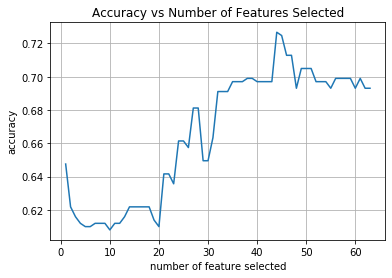

The optimal choice of the number of features is: 44
The accuracy generated by it is: 0.7267326732673267


In [8]:
#feature engineering
#using interaction term pairs

#make a copy of the training set and test set from the split
x_train_interaction_pairs = x_train.copy()
x_test_interaction_pairs = x_test.copy()

#generating new features using interaction term paris
for i in range(len(x_train.columns)):
    for j in range(i+1, len(x_train.columns)):
        x_train_interaction_pairs[f"{x_train.columns[i]} x {x_train.columns[j]}"] \
        = x_train.iloc[:,i] * x_train.iloc[:,j]
        x_train_interaction_pairs[f"{yeast_data.columns[i]} / {yeast_data.columns[j]}"] \
        = x_train.iloc[:,i] / x_train.iloc[:,j]

for i in range(len(x_test.columns)):
    for j in range(i+1, len(x_test.columns)):
        x_test_interaction_pairs[f"{x_test.columns[i]} x {x_test.columns[j]}"] \
        = x_test.iloc[:,i] * x_test.iloc[:,j]
        x_test_interaction_pairs[f"{yeast_data.columns[i]} / {yeast_data.columns[j]}"] \
        = x_test.iloc[:,i] / x_test.iloc[:,j]

#discretise data in order to compute mutual information
discretised_x_train_interaction_pairs \
= x_train_interaction_pairs.apply(lambda column: pd.cut(column, 3, labels=["low", "medium", "high"]), axis=0)

#compute mutual information in the training set
mutual_info_scores = []
for column in discretised_x_train_interaction_pairs:
    mutual_info_scores.append(metrics.normalized_mutual_info_score(discretised_x_train_interaction_pairs[column], 
                                                                   y_train, average_method='min'))

#put feature names and its normalised mutual information into a series
nmi = pd.Series(mutual_info_scores, index=discretised_x_train_interaction_pairs.columns)

#experiment with the number of features with highest MI values to be selected
numbers_of_paris = np.arange(1, len(x_train_interaction_pairs.columns))
acc_interaction_pairs = []
for n in numbers_of_paris:
    selected_features = nmi.sort_values(ascending=False)[:n].index
    x_train_new = x_train_interaction_pairs.loc[:, selected_features]
    x_test_new = x_test_interaction_pairs.loc[:, selected_features]

    knn10 = neighbors.KNeighborsClassifier(n_neighbors=10)
    knn10.fit(x_train_new, y_train)
    y_pred_knn10 = knn10.predict(x_test_new)
    acc_interaction_pairs.append(accuracy_score(y_test, y_pred_knn10))

plt.plot(numbers_of_paris, acc_interaction_pairs)
plt.title("Accuracy vs Number of Features Selected")
plt.ylabel("accuracy")
plt.xlabel("number of feature selected")
plt.grid()
plt.show()

print(f"The optimal choice of the number of features is: {np.argmax(acc_interaction_pairs)+1}")
print(f"The accuracy generated by it is: {max(acc_interaction_pairs)}")

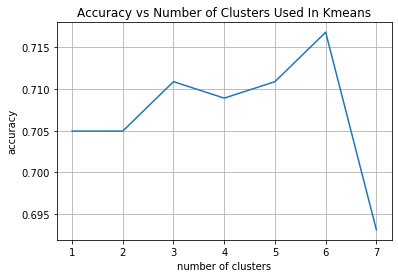

The optimal choice of the number of clusters is: 6
The accuracy generated by it is: 0.7168316831683168


In [15]:
#using clustering labels
x_train_with_label = x_train.copy()
x_test_with_label = x_test.copy()

#define a function to be used to assign the instances in the test set to its nearest cluster
def find_cluster_label(row):
    distances = [np.sqrt(sum(pow(row-center, 2))) for center in km.cluster_centers_]
    return np.argmin(distances)

#experiment with different choices of clusters used in kmeans
acc_clustering_labels = []
for k in range(1, 8):
    km = KMeans(n_clusters=k)
    km.fit(x_train)
    
    x_train_with_label["clusterlabel"] = km.labels_
    x_test_with_label["clusterlabel"] = x_test.apply(find_cluster_label, axis=1)
    
    knn = neighbors.KNeighborsClassifier(n_neighbors=10)
    knn.fit(x_train_with_label, y_train)
    y_pred_knn = knn.predict(x_test_with_label)
    acc_clustering_labels.append(accuracy_score(y_test, y_pred_knn))

plt.plot(np.arange(1, 8), acc_clustering_labels)
plt.title("Accuracy vs Number of Clusters Used In Kmeans")
plt.xlabel("number of clusters")
plt.ylabel("accuracy")
plt.grid()
plt.show()

print(f"The optimal choice of the number of clusters is: {np.argmax(acc_clustering_labels)+1}")
print(f"The accuracy generated by it is: {max(acc_clustering_labels)}")

Feature Engineering - Discussion

In this section, I used k=10 for KNN because because I found it has better performance after some trials.

For the method of interaction term pairs, I generate all the possible combinations and then apply feature selection.
I calculate the mutual information and sort the features according to it.
In order to figure out how many features to choose, I plot a graph of accuracies generated by differenct choices of number of features.
And I find that the optimal choice is to choose 44 features, which gives me an accuracy of around 72.6%.
Based on this observation, it could be said that feature selecation and generation could increase the accuracy. But the gain is not much, because the original accuracy is 70%.

For the method of clustering labels, I first perform kmeans clustering on the training set and then assign the instances in the test set to its nearest cluster.
In order to find the optimal choice of k for kmeans, I plot a graph again.
And the graph tells me the optimal choice for k is 6, which gives me around 71% accuracy. Compared with the original 70% accuracy, it does not increase very much, but at least increase slightly anyway.

The graphs and results may change each time it runs. The data in the above discussion is from the time that I run it.
I print the highest accuracy and the choice of parameter that generate it at the bottom of the graphs.